In [58]:
import requests
import random
import pandas as pd
import os, pickle
import numpy as np
import networkx as nx
%matplotlib inline
from matplotlib import pyplot as plt
plt.style.use("classic");plt.style.use("seaborn-pastel")
plt.rcParams['figure.figsize'] = (15.25,8.75)
from math import sin, cos, radians, degrees, asin, atan2, sqrt
import shapely
from shapely.geometry import Point, LineString, Polygon
from copy import deepcopy as copy
from collections import Counter
from pprint import pprint as pp

### API keys

Insert cred.json here : form : json[source][keys]

In [1]:
data_sources = {"source" : {"keys" : []}}

### Data retrieval

In [10]:
def yelp_search(loc, query, r, limit,cats=""):
    """Note: The API does not return businesses without any reviews."""
    global data_sources
    key = random.choice(data_sources["yelp"]["keys"])
    lat, lon = loc[0], loc[1]
    url = "https://api.yelp.com/v3/businesses/search"
    params = { "latitude" : lat, "longitude" : lon, "radius" : r, "term" : query, "categories" : cats, "limit" : limit }
    headers = {"Authorization" : "Bearer {}".format(key[1])}
    return requests.get(url,params=params,headers=headers).json()["businesses"]

def yelp_details(yid):
    global data_sources
    key = random.choice(data_sources["yelp"]["keys"])
    url = "https://api.yelp.com/v3/businesses/{}".format(yid)
    headers = {"Authorization" : "Bearer {}".format(key[1])}
    return requests.get(url,headers=headers).json()

def fb_search(coord, query, r, limit, cats ="", all_fields=True,interest=""):
    global data_sources
    key = random.choice(data_sources["facebook"]["keys"])
    r="" if coord=="" else r
    if type(coord) == tuple:
        c = str(coord).replace("(","").replace(")","")
    elif type(coord) == str:
        c = coord.replace("(","").replace(")","")
    elif type(coord) == shapely.geometry.point.Point:
        fb_obj(list(coord.coords)[0])
    fields = "id, about, hours, category_list, checkins, description, engagement, is_verified, link, location, name, overall_star_rating, parking, payment_options, phone, price_range, rating_count, restaurant_services, restaurant_specialities, website" if all_fields else interest
    #fields = "name,overall_star_rating,website,rating_count,price_range,phone,payment_options,hours,location,restaurant_services,restaurant_specialties,parking" if all_fields else interest
    url = "https://graph.facebook.com/v3.2/search?type=place&center={c}&distance={d}&q={query}&fields={f}&limit={l}&categories={cats}&access_token={k}".format(c=c, d=r, f=fields,l=limit, k=key,query=query, cats=cats)
    return requests.get(url).json()["data"]

def yelp_reviews(yid):
    global data_sources
    key = random.choice(data_sources["yelp"]["keys"])
    url = "https://api.yelp.com/v3/businesses/{}/reviews".format(yid)
    headers = {"Authorization" : "Bearer {}".format(key[1])}
    return requests.get(url,headers=headers).json()

def fs_search(coord, query, r,limit,intent="browse"): 
    global data_sources
    url = 'https://api.foursquare.com/v2/venues/explore'
    key = random.choice(data_sources["4square"]["keys"])  
    #key = data_sources["4square"]["keys"][0]
    params = dict(
      client_id=key[0],
      client_secret=key[1],
      intent=intent,
      v='20180323',
      radius=r,
      ll=str(coord).replace("(","").replace(")",""),
      query=query,
      limit=limit,
      llAcc=1000
    )
    return requests.get(url=url, params=params).json()["response"]["groups"][0]["items"]

def fs_venue(vid, meta=False, ov=False):
    global data_sources
    key = random.choice(data_sources["4square"]["keys"])
    #key = data_sources["4square"]["keys"][0]
    if ov:
        url = "https://api.foursquare.com/v2/venues/{v}?client_id={k0}&client_secret={k1}&v=20170801".format(v=vid,k0=key[0], k1=key[1])
    else:       
        url = "https://api.foursquare.com/v2/venues/{v}?client_id={k0}&client_secret={k1}&v=20180323".format(v=vid,k0=key[0], k1=key[1])
    return requests.get(url).json() if meta else requests.get(url).json()["response"]

def fs_tips(vid,meta =False):
    global data_sources
    key = random.choice(data_sources["4square"]["keys"])
    url = "https://api.foursquare.com/v2/venues/{v}/tips?client_id={k0}&client_secret={k1}&v=20180323".format(v=vid,k0=key[0], k1=key[1])
    return requests.get(url).json() if meta else requests.get(url).json()["response"]

def nearby_photos(coord,query,r=15):
    """
    IMPORTANT : Geo queries require some sort of limiting agent in order to prevent the database from crying. This is basically like the check against "parameterless searches" for queries without a geo component. 

A tag, for instance, is considered a limiting agent as are user defined min_date_taken and min_date_upload parameters — If no limiting factor is passed we return only photos added in the last 12 hours (though we may extend the limit in the future)."""
    r = r/1000
    global data_sources
    key =  random.choice(data_sources["flickr"]["keys"])[0]
    lat, lon = coord[0], coord[1]
    call =  flickr.photos.search(text=query,radius=r,lat=lat, lon=lon, api_key = key[0],accuracy=16,content_type=7,extras="description, date_upload, owner_name, tags, geo, views", per_page=500, format='parsed-json')
    return call


def get_comments(pid):
    global data_sources
    key =  random.choice(data_sources["flickr"]["keys"])[0]
    call = flickr.photos.comments.getList(api_key = key[0],photo_id=pid,format='parsed-json')
    return call

def match_photo(foto, name):
    """naive solution for matching nearby photos with poi"""
    name = name.lower()
    tags = foto["tags"].lower()
    title = foto["title"].lower()
    descr = foto["description"]["_content"].lower()
    return 1 if any([name in tags, name in title, name in descr]) else 0 

def here_search(coords, query, radius, limit, cat=""):
    app_id, app_code = "d1iItfhpkXFKqYXIW1zU", "JSX8VzJifJO8lY99ScrifQ"
    lat, lon = coords
    base = "https://places.cit.api.here.com/places/v1/discover/search?app_id={}&app_code={}".format(app_id, app_code)
    params = "&in={},{};r={}&cat={}&size={}&q={}&pretty".format(lat, lon, radius, cat, limit, query)     
    url = base + params
    add_params = {"recd" : False}
    r = requests.get(url, add_params)
    return r.json()["results"]["items"]

In [11]:
def parse_hours(poi):
    """optional"""
    def is_hour(s):
        try:
            return all([s[i].isdigit() for i in [0,1,3,4]])
        except:
            return False
    hours = {}
    day_keys = ["mo", "tu", "we", "th", "fr", "sa", "su"]
    day_int_keys = { i : day_keys[i] for i in range(0, len(day_keys))}
    if "opening_hours" not in poi["tags"]:
        return None
    else:
        string = poi["tags"]["opening_hours"]
        if string[0:3] != "Mo-":
            return None
        else:
            start = "mo"
            last = string[3:5]
            if last.lower() not in ["fr", "sa", "su"]:
                return None
            last = last.lower()
            begin = string[6:11]
            end = string[12:17]
            if not is_hour(begin) and not is_hour(end):
                return None
            for day in day_keys[:day_keys.index(last)+1]:
                hours[day] = begin+"-"+end
            for day in day_keys:
                if day not in hours:
                    hours[day] = None
            if len(string)  == 17:
                return hours
            elif string[17:21] == '; Sa':
                if all([is_hour(string[22:27]), is_hour(string[28:33]) ]):
                    hours["sa"] = string[22:27]+"-"+string[28:33]
                if string == "; Su" and all([is_hour(string[38:43]), is_hour(string[44:49]) ]):
                    hours["su"] = string[38:43]+"-"+string[44:49]
                    
                
            elif string[17:21] == '; Su':
                if all([is_hour(string[22:27]), is_hour(string[28:33]) ]):
                    hours["su"] = string[22:27]+"-"+string[28:33]
            
            return hours
       

In [13]:
def get_data(poi_osm, radius=150, maxresults=3, verbose=False):
    poi = copy(poi_osm)
    loc, name = poi["location"], poi["tags"]["name"]
    street, housenumber = poi["tags"]['addr:street'], poi["tags"]['addr:housenumber']
    address = street + " " + housenumber
    poi["address"] = address
    for tag in poi["tags"]:
        if tag == "url" or tag == "website":
            poi["url"] = poi["tags"][tag]
        elif "addr" in tag or tag == "opening_hours":
            continue
        elif tag == "phone" or tag=="fax":
            poi[tag] = poi["tags"][tag].replace(" ", "")
        else:
            poi[tag] = poi["tags"][tag]
    poi["hours"] = parse_hours(poi)
    del poi["tags"]
    poi["source"] = "OSM"
    pool = [poi]
    day_keys = ["mo", "tu", "we", "th", "fr", "sa", "su"]
    day_int_keys = { i : day_keys[i] for i in range(0, len(day_keys))}
    ### Data Sources ###
    # Each data source will return a list of potential results.
    #Facebook 
    fb = fb_search(loc,
              query=name,
              r=radius,
              limit=maxresults,
              cats ="", all_fields=True, interest="")
    print("FB RESULTS : ", len(fb)) if verbose else None
    for res in fb:
        out = {"source" : "facebook"}
        out["rating"] = res.get('overall_star_rating')
        out["name"] = res.get("name")
        out["phone"] = res.get("phone")
        if out["phone"] != None:out["phone"] = out["phone"].replace(" ", "")
        out["checkins"] = res.get("checkins")
        out["address"] = res["location"]["street"] if "street" in res["location"] else None
        out["location"] = res["location"]['latitude'], res["location"]['longitude']
        out["url"] = res.get("website")
        if "hours" in res:
            hours = dict()
            for i in range(0, len(res["hours"])-1):
                if i%2 != 0:
                    continue
                day = res["hours"][i]["key"][0:2]
                h =  res["hours"][i]["value"]+"-"+res["hours"][i+1]["value"]
                hours[day] = h
            for key in day_keys:
                if key not in hours:
                    hours[key] = None
            out["hours"] = hours
        else:
            out["hours"] = None
    
        pool.append(out)
    
    #Yelp
    yelp = yelp_search(loc,
                r=radius,
                query=name,
                cats="",limit=maxresults)
    print("YELP RESULTS : ", len(yelp)) if verbose else None
    for res in yelp:
        res = yelp_details(res["id"])
        out = {"source" : "yelp"}
        out["name"] = res.get("name")
        out["url"] = None
        out["address"] = res['location']["address1"] if "address1" in res['location'] else None
        out["rating"] = res.get("rating")
        out["location"] = tuple(res['coordinates'].values())
        out["phone"] = res.get("phone")
        if out["phone"] != None:out["phone"] = out["phone"].replace(" ", "")
        if "hours" in res:  
            hours = dict()    
            for i in range(0, len(res["hours"][0]["open"])):
                entry = res["hours"][0]["open"][i]
                day = day_int_keys[entry["day"]]
                h = entry["start"][0:2]+":"+entry["start"][2:]+"-"+entry["end"][0:2]+":"+entry["end"][2:]
                hours[day] = h
            out["hours"] = hours
        else:
            out["hours"] = None
            
        pool.append(out)

    #Foursquare
    fs = fs_search(loc,
              query=name,
              r=radius,
              intent="browse",limit=maxresults)
    print("Foursquare RESULTS : ", len(fs)) if verbose else None
    for res in fs:
        res = res["venue"]
        res = fs_venue(res["id"])["venue"]
        out = {"source" : "foursquare"}
        out["name"] = res.get("name")
        out["url"] = res.get("url")
        out["phone"] = res["contact"]["phone"] if "phone" in res["contact"] else None
        out["address"] = res["location"]["address"] if "address" in res["location"] else None
        out["location"] = (res["location"]["lat"], res["location"]["lon"]) if "lat" in res["location"] and "lon" in res["location"] else None
        out["likes"] = res["likes"]["count"] if "likes" in res else None
        out["rating"] = res.get("rating")
        out["hours"] = None #TODO
        if out["phone"] != None:out["phone"] = out["phone"].replace(" ", "")
        
        pool.append(out)
        
    #HERE
    here = here_search(loc,
                query=name,
                cat="", radius=radius,limit=maxresults)
    print("HERE RESULTS : ", len(here)) if verbose else None
    for res in here:
        out = {"source" : "here"}
        out["name"] = res.get("title")
        out["location"] = tuple(res["position"])
        out["rating"] = res.get("averageRating")
        out["address"] = res["vicinity"].split("<")[0] 
        out["names"] = [i["name"] for i in res["alternativeNames"]] if "alternativeNames" in res else None
        out["hours"] = None #TODO
        pool.append(out)

    for item in pool:
        if item["hours"] != None:
            for day in item["hours"]:
                if item["hours"][day] != None:
                    if "24" in item["hours"][day]:
                        item["hours"][day] = item["hours"][day].replace("24", "00")
                    
    return pool

### Geometric utilities

In [15]:
def destination_point(p:tuple, bearing:int,
                      d:float) -> tuple:
        lat1, lon1 = p
        lat1, lon1 = radians(lat1), radians(lon1)
        R = 6378.1                   #Radius of the Earth
        brng = radians(bearing) #convert degrees to radians
        d = d/1000                  #convert to m
        lat2 = asin( sin(lat1)*cos(d/R) + cos(lat1)*sin(d/R)*cos(brng))
        lon2 = lon1 + atan2(sin(brng)*sin(d/R)*cos(lat1),cos(d/R)-sin(lat1)*sin(lat2))
        return degrees(lat2), degrees(lon2)
       
def ellipse(p:tuple,
            r:float=10.) -> shapely.geometry.Polygon:
    return Polygon([destination_point(p, bearing, r) for bearing in range(0,361,10)])
def haversine(c1:tuple, c2:tuple) -> float:
    """returns the haversine distance in Meters"""
    lat1, lon1, lat2, lon2 = c1[0], c1[1], c2[0], c2[1]
    
    # convert decimal degrees to radians 
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    r = 6371 # Radius of earth in kilometers
    return c * r * 1000

### POI (OSM) retrieval

In [16]:
def get_pois(town, density_r, n):
    overpass_url = "http://overpass-api.de/api/interpreter"
    overpass_query = """
[out:json][timeout:1000];
area[name="{town}"]->.searchArea;
(
  node["name"]["amenity"]["addr:street"]["addr:housenumber"](area.searchArea);
);
out body;
>;
out skel qt;


""".format(town=town)
    response = requests.get(overpass_url, params = {"data" : overpass_query})
    data = response.json()
    elements = copy(data["elements"])
    sample = random.sample(data["elements"], n)
    #Modify attributes
    for poi in sample:
        del poi["type"]
        poi["location"] = (poi["lat"], poi["lon"])
        del poi["lat"]
        del poi["lon"]
        poi["density"] = -1
        circle = ellipse(poi["location"], density_r)
        for poi2 in elements:
            c = Point((poi2["lat"], poi2["lon"]))
            if c.within(circle):
                poi["density"] += 1
    return sample
def collect_pois(towns, density_r=50,subsample_size=200):
    sample, pois = [], []
    for town in towns:
        try:
            pois.append(get_pois(town, density_r, subsample_size))
        except:
            print("Error while collecting data from town ", town)
            continue
    for l in pois:    
        for poi in l:
            dist = Counter([poi["tags"]["amenity"] for poi in sample])
            density_q = np.quantile([_["density"] for _ in l], .95)
            tags_q = np.quantile([len(_["tags"]) for _ in l], .95)
            if poi["density"] >= density_q:
                sample.append(poi)
            elif len(poi["tags"]) >= tags_q:
                sample.append(poi)
            elif poi["tags"]["amenity"] not in dist:
                sample.append(poi)
            elif dist.get(poi["tags"]["amenity"]) == min(dist.values()):
                sample.append(poi)
            
    return sample    

## Collect a set of POIs for the experiment

Generate a high variance sample of POIs.

Definition of POI :
- has name tag
- has amenity tag
- has address tag

Attributes:
- POI density (measured as the total POIs around the POI loction within radius $r$.
- Amenity
- Country
- len tags



In [9]:
poi_sample = collect_pois(towns=["München", "Berlin", "Heidelberg", "Köln"],
                   density_r=50, subsample_size=500)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0xa21d53190>,
      dtype=object)

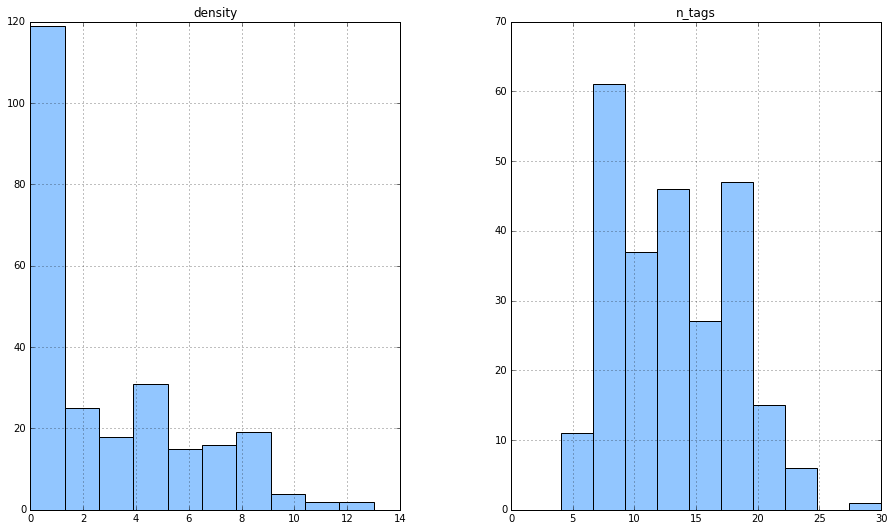

In [55]:
# Attribute Dist for the collected poi sample
pd.DataFrame({"density" : [_["density"] for _ in poi_sample],
              "n_tags" : [len(_["tags"]) for _ in poi_sample],
             "amenity" : [_["tags"]["amenity"] for _ in poi_sample]}).hist()

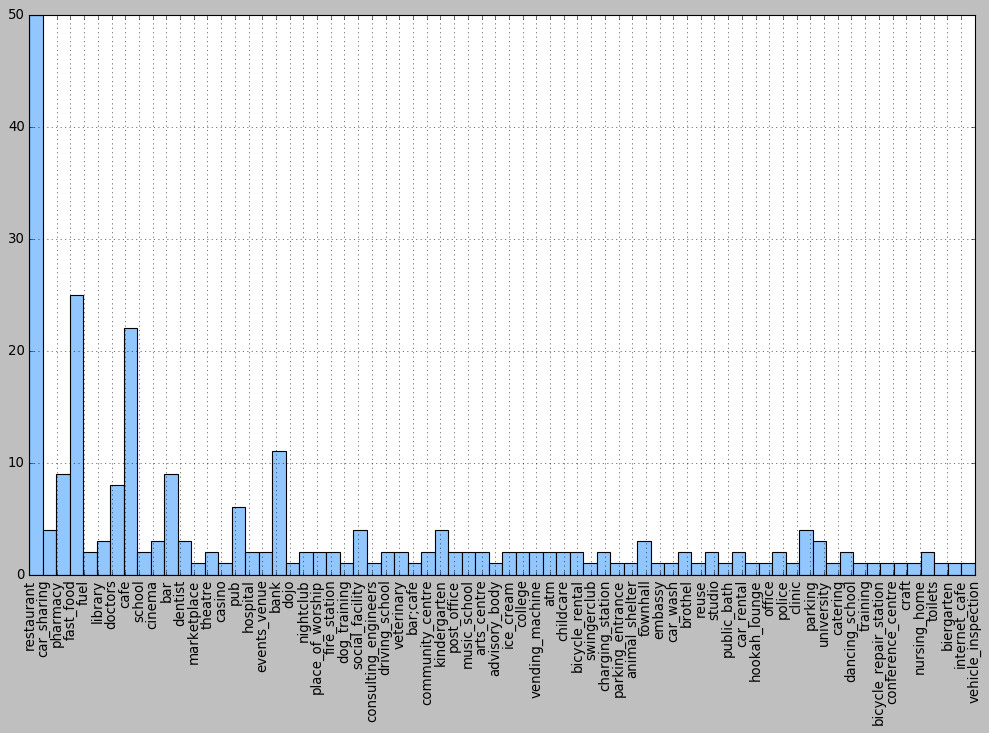

In [81]:
##amenity dist
pd.Series([_["tags"]["amenity"] for _ in poi_sample]).hist(bins=70);
plt.xticks(rotation='vertical');plt.show()

Now the given OSM attributes are used to retrieve 3 candidates per data source

In [ ]:
results = []

In [554]:
for poi in poi_sample:
    if poi["tags"]["name"] not in x:
        results.append(get_data(poi))
        time.sleep(1)

In [10]:
#Remove results without any other sources than osm
results = [i for i in results if len(i) > 1]
len(results)

500

In [ ]:
#save data 
with open("network_data", "wb") as f:
    pickle.dump(results, f)